# Imports

In [206]:
import pandas as pd
import bson
import json
import numpy as np
import pprint
from geopy.geocoders import Nominatim
from geopy.distance import great_circle
import os
import statistics
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

# Data Reading

In [207]:
try:
    os.mkdir('./assignment')
except FileExistsError:
    pass

In [208]:
json_data = None
with open('./mongodump_10users/mobycy_prodmongo/track_ride.metadata.json', 'r') as f:
    data = f.read()
    json_data = json.loads(data)

pprint.pprint(json_data)

{'collectionName': 'track_ride',
 'indexes': [{'key': {'_id': {'$numberInt': '1'}},
              'name': '_id_',
              'v': {'$numberInt': '2'}},
             {'key': {'latitude': {'$numberInt': '1'}},
              'name': 'latitude',
              'v': {'$numberInt': '2'}},
             {'key': {'createdTime': {'$numberDouble': '1.0'}},
              'name': 'createdTime_1',
              'v': {'$numberInt': '2'}},
             {'key': {'imei': {'$numberDouble': '1.0'}},
              'name': 'imei_1',
              'v': {'$numberInt': '2'}},
             {'key': {'userId': {'$numberInt': '1'}},
              'name': 'userId',
              'v': {'$numberInt': '2'}},
             {'key': {'rideId': {'$numberInt': '1'}},
              'name': 'rideId',
              'v': {'$numberInt': '2'}},
             {'key': {'cycleId': {'$numberInt': '1'}},
              'name': 'cycleId',
              'v': {'$numberInt': '2'}},
             {'key': {'trackTime': {'$numberInt': '1'}},


In [209]:
dd = './mongodump_10users/mobycy_prodmongo/track_ride.bson'
with open(dd,'rb') as f:
    data = bson.decode_all(f.read())
df = pd.DataFrame.from_dict(data) # won't be needed if the data is retrieved from mongo

In [211]:
geolocator = Nominatim(user_agent="geoapiExercises")

# Missing Data
1. Filled the NaN userIds and rideIds using imei (I believe users’ device id), since each user has only one imei, rideId and cycleId.

In [212]:
len(df[df['rideId'].isna()])

1876

In [214]:
print(len(df[df['userId'].isnull()]))
print(df['imei'].isnull().sum())

1876
0


In [215]:
def calc_distance(points):
    # great circle, is an approx of haversine. return distance in kms.
    cumulative_distance = 0.0
    for i in range(len(points) - 1):
        point1 = points[i][0], points[i][1]
        point2 = points[i + 1][0], points[i + 1][1]
        distance = great_circle(point1, point2).kilometers
        cumulative_distance += distance
    return round(cumulative_distance,2)

In [216]:
nan_rows = df[df['rideId'].isna()]
nan_time = nan_rows['createdTime'].sort_values(ascending=True)
nan_dist = list(zip(nan_rows['latitude'], nan_rows['longitude']))
nan_dist = calc_distance(nan_dist)
print("Duration min of the nan trip (if considered 1): ",nan_time.iloc[-1] - nan_time.iloc[0])
print("Distance km of the nan trip (if considered 1): ",nan_dist)
print("Speed of the nan trip (if considered 1): ",np.mean(nan_rows['speed']),np.std(nan_rows['speed']))

Duration min of the nan trip (if considered 1):  0 days 23:59:08.622000
Distance km of the nan trip (if considered 1):  21236.87
Speed of the nan trip (if considered 1):  1.2563965884861408 4.445816487842301


In [217]:
imei_user = {}
imei = df['imei'].unique()
for i in imei:
    imei_user[i] = df[(df['imei'] == i) & (df['userId'].isnull()==False)]['userId'].unique()[0]

imei_ride = {}
for i in imei:
    imei_ride[i] = df[(df['imei'] == i) & (df['rideId'].isnull()==False)]['rideId'].unique()[0]

In [218]:
df['userId'] = df['imei'].map(imei_user)
df['rideId'] = df['imei'].map(imei_ride)

In [239]:
df.isnull().sum()

_id             0
_class          0
clientSideId    0
imei            0
userId          0
rideId          0
cycleId         0
latitude        0
longitude       0
source          0
accuracy        0
trackTime       0
lockStatus      0
createdTime     0
rawData         0
speed           0
dtype: int64

# EDA

In [219]:
def cyc_sec(time_vec,plot=False): #calculate  cycles per second
    n = time_vec.iloc[0]
    avgs = []
    while n < time_vec.iloc[-1]:
        recs = len(time_vec[(time_vec >n) & (time_vec<n+ 1e+9)])
        avgs.append(recs)
        n= n+1e+9
    return round(np.mean(avgs)), statistics.mode(avgs), round(np.std(avgs))

userids = df['userId'].unique()
data_per_user = []
for i in userids:
    x = df[df['userId']==i]['trackTime'].sort_values()
    me,_,std = cyc_sec(x)
    data_per_user.append((me,std))
    
print("trip logs with Nan",len(df[df['rideId'].isna()]))
acc, med, accstd = df['accuracy'].mean(), df['accuracy'].median(), df['accuracy'].std()
print(f"Accuracy of the GPS: Mean {acc}, Median {med}, Std {accstd} ")
fs, med, fsstd = cyc_sec(df['trackTime'].sort_values())
print(f"Samples/data recieved per second: Mean {fs}, Median {med}, Std {fsstd}")
print(f"Average records per user: {np.mean([i[0] for i in data_per_user])} with Std: {np.std([i[0] for i in data_per_user])}")
data_per_user

trip logs with Nan 0
Accuracy of the GPS: Mean 0.0, Median 0.0, Std 0.0 
Samples/data recieved per second: Mean 40174, Median 40174, Std 0
Average records per user: 4016.5 with Std: 506.2888997400595


[(3599, 0),
 (3679, 0),
 (3747, 0),
 (4891, 0),
 (3688, 0),
 (4764, 0),
 (4519, 0),
 (4155, 0),
 (3768, 0),
 (3355, 0)]

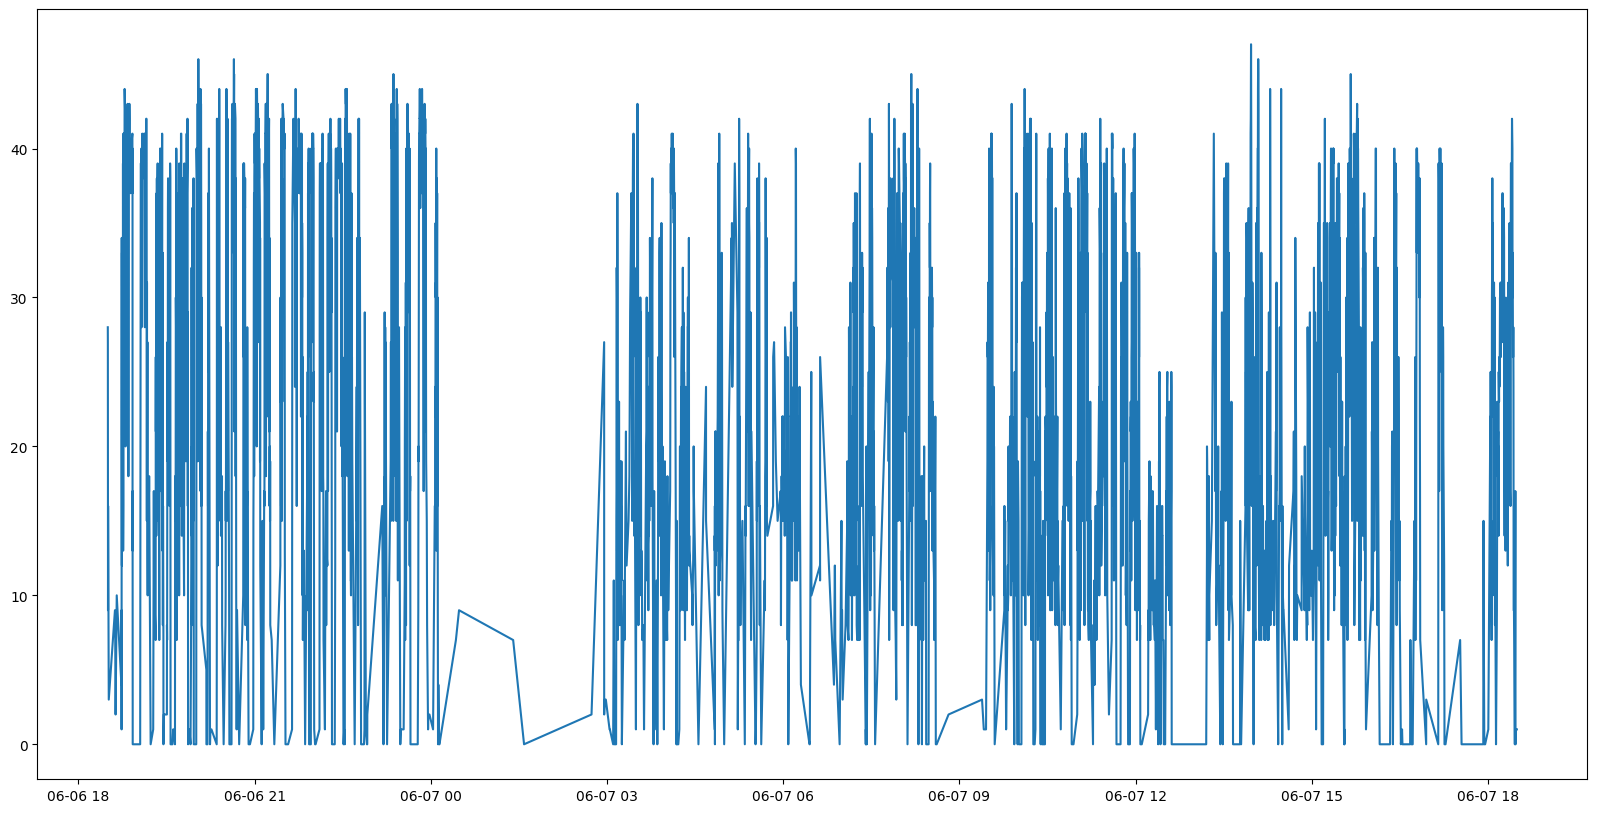

In [220]:
plt.plot(df[df['userId']==userids[0]]['createdTime'].sort_values(), df[df['userId']==userids[0]]['speed'])

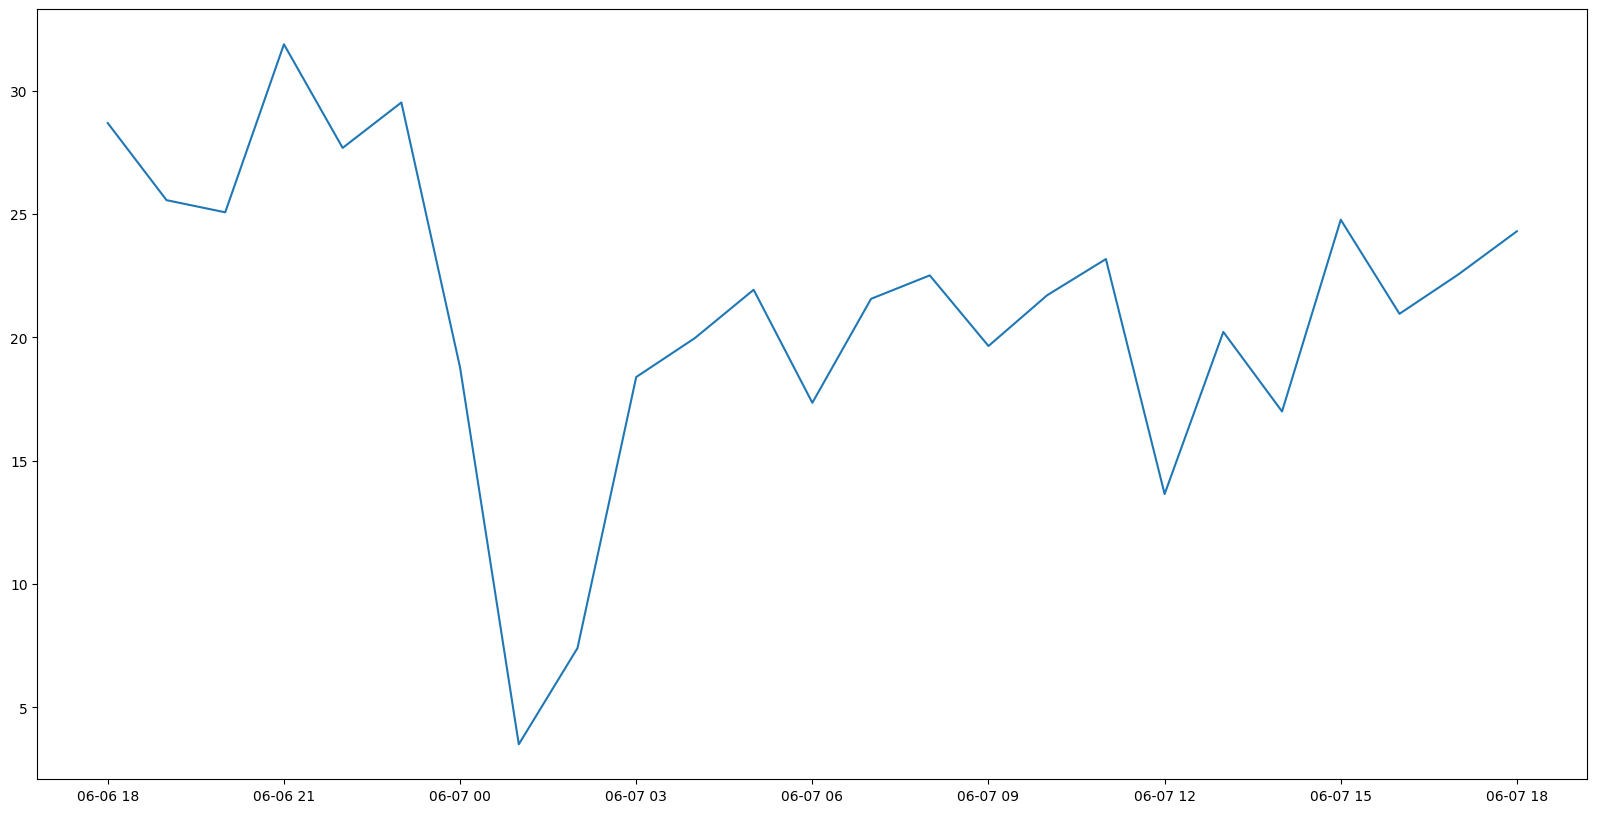

In [221]:
x = df[df['userId']==userids[0]][['createdTime','speed']].sort_values('createdTime')
x = x.set_index('createdTime').resample('1H').mean()
plt.plot(x)

In [222]:
(x['speed'] >0.0).sum()

25

In [223]:
wrk_hrs = []
for i in userids:
    x = df[df['userId']==i][['createdTime','speed']].sort_values('createdTime')
    x = x.set_index('createdTime').resample('1H').mean()
    wrk_hrs.append((x['speed'] >0.0).sum())

In [224]:
np.mean(wrk_hrs), np.std(wrk_hrs)

(21.3, 2.6095976701399777)

# Data Preprocessing

1. Selected the unique ride ids.
3. Selected the individual trip's start and end point by grouping by the ride id and sorting by trackTime.
4. Used Nominatim API to get state name from the lat, long.
5. Calculated an estimated shortest distance between start and end point with Haversine Formula. (calculating dist btwn each indivisual trip log of the trip will give more accuracy)

In [227]:
user_ids  =df['userId'].unique()
user_ride_id = {}

In [228]:
def calc_distance(points):
    # great circle, is an approx of haversine. return distance in kms.
    cumulative_distance = 0.0
    for i in range(len(points) - 1):
        point1 = points[i][0], points[i][1]
        point2 = points[i + 1][0], points[i + 1][1]
        distance = great_circle(point1, point2).kilometers
        cumulative_distance += distance
    return round(cumulative_distance,2)

In [229]:
for i in range(len(user_ids)):
    x = df[df['userId']==user_ids[i]].sort_values('trackTime',ascending=True) #else use min and max 
    if len(x['rideId'])>0:
        user_ride_id[i] = {}
        user_ride_id[i]['userId'] = user_ids[i]
        user_ride_id[i]['rideId'] = x['rideId'].iloc[0]

        start_time = x['trackTime'].iloc[0]
        user_ride_id[i]['startTime'] =start_time
        end_time = x['trackTime'].iloc[-1]
        user_ride_id[i]['endTime'] = end_time

        lat1 = x['latitude'].iloc[0]
        long1 = x['longitude'].iloc[0]
        user_ride_id[i]['startLat'] = lat1
        user_ride_id[i]['startLong'] = long1
        lat2 = x['latitude'].iloc[-1]
        long2 = x['longitude'].iloc[-1]
        user_ride_id[i]['endLat'] =lat2
        user_ride_id[i]['endLong'] = long2

        location = geolocator.reverse(str(lat1)+","+str(long1))
        address = location.raw['address']
        state = address.get('state', '')
        user_ride_id[i]['startstate'] = state

        user_ride_id[i]['avg_speed'] = round(np.mean(x['speed']),2)
        user_ride_id[i]['dur_min'] = round((end_time- start_time) / (1e+3*60),2)

        # calculating approx distances, for higher accuracy fo the distance iterate over the 
        # list and calculate the distance between prev and next point increment the initial distance.
        points = list(zip(x['latitude'], x['longitude']))
        user_ride_id[i]['distance_km'] = calc_distance(points)
        user_ride_id[i]['color'] = None


In [230]:
user_ride_id[0]

{'userId': 363269.0,
 'rideId': 29244162.0,
 'startTime': 1686076200484,
 'endTime': 1686162578231,
 'startLat': 28.49128333333333,
 'startLong': 77.19214611111111,
 'endLat': 28.557882222222222,
 'endLong': 77.16329166666667,
 'startstate': 'Delhi',
 'avg_speed': 23.22,
 'dur_min': 1439.63,
 'distance_km': 265.74,
 'color': None}

In [231]:
min([user_ride_id[i]['dur_min'] for i in user_ride_id]), max([user_ride_id[i]['dur_min'] for i in user_ride_id])

(1048.13, 1439.9)

In [232]:
# Function to determine color based on duration quantiles

# Define colors for quantiles
quantile_colors = ['green','blue','purple','orange','red']

def get_color(duration, quantiles):
    for i, quantile in enumerate(quantiles):
        if duration <= quantile:
            return quantile_colors[i]
    return quantile_colors[-1]

# Extract trip durations and calculate quantiles
trip_durations = [trip_data['dur_min'] for trip_data in user_ride_id.values()]
quantiles = np.percentile(trip_durations, [20, 40, 60, 80])
print(quantiles)

for i in user_ride_id:
    user_ride_id[i]['color']  = get_color(user_ride_id[i]['dur_min'],quantiles)

[1298.79  1432.338 1439.116 1439.658]


# Saving Structured Data

In [234]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


with open("./assignment/processed.json", "w") as outfile:
    json.dump(user_ride_id, outfile,cls =NpEncoder)

# Map Creation
1. Used folium to generate map and plot points on map (openstreetmaps).
2. Used Quantiles for allocating colors to trips based on duration in minutes. (as the durations range between 893.66 - 1439.9 mins) (not sure if this is a trip or certain trips in a day)
3. Saved the map in html format.

In [236]:
import folium
import numpy as np

# Create a base map centered around the first trip's start location
m = folium.Map(
    location=[user_ride_id[0]['startLat'], user_ride_id[0]['startLong']],
    zoom_start=10  # You can adjust the zoom level as needed
)



# Plot start and end points for each trip and connect with colored lines based on duration quantiles
for trip_id, trip_data in user_ride_id.items():
    start_lat = trip_data['startLat']
    start_long = trip_data['startLong']
    end_lat = trip_data['endLat']
    end_long = trip_data['endLong']
    duration_minutes = trip_data['dur_min']
    avg_speed = trip_data['avg_speed']
    distance = round(trip_data['distance_km'],2)

    # Determine the color based on duration quantiles
    line_color = trip_data['color']

    
    # Create markers for start and end points with tooltips
    start_tooltip = f"Duration: {duration_minutes} min<br>Avg Speed: {avg_speed} km/h<br> Distance: {distance} km"
    start_marker = folium.CircleMarker(
        location=[start_lat, start_long],
        color=line_color,
        radius=5,
        fill=True,
        fill_color=line_color,
        fill_opacity=0.7,
        tooltip=start_tooltip,
    )

    end_marker = folium.CircleMarker(
        location=[end_lat, end_long],
        color=line_color,
        radius=5,
        fill=True,
        fill_color=line_color,
        fill_opacity=0.7,
        tooltip=start_tooltip,
    )


    # Create a polyline connecting the start and end points
    polyline = folium.PolyLine(
        locations=[(start_lat, start_long), (end_lat, end_long)],
        color=line_color,
        weight=2,
    )

    # Add markers and polyline to the map
    m.add_child(start_marker)
    m.add_child(end_marker)
    m.add_child(polyline)

m.save('./assignment/trip_map.html')


In [237]:
# Calculate state-wise trip counts (same as in previous code)
state_trip_counts = {}
for trip_data in user_ride_id.values():
    start_state = trip_data.get('startstate')
    if start_state:
        if start_state in state_trip_counts:
            state_trip_counts[start_state] += 1
        else:
            state_trip_counts[start_state] = 1

In [238]:
user_ride_id

{0: {'userId': 363269.0,
  'rideId': 29244162.0,
  'startTime': 1686076200484,
  'endTime': 1686162578231,
  'startLat': 28.49128333333333,
  'startLong': 77.19214611111111,
  'endLat': 28.557882222222222,
  'endLong': 77.16329166666667,
  'startstate': 'Delhi',
  'avg_speed': 23.22,
  'dur_min': 1439.63,
  'distance_km': 265.74,
  'color': 'orange'},
 1: {'userId': 344898.0,
  'rideId': 2909970.0,
  'startTime': 1686076201703,
  'endTime': 1686162347989,
  'startLat': 28.49561277777778,
  'startLong': 77.10076111111111,
  'endLat': 28.47936222222222,
  'endLong': 77.08066555555556,
  'startstate': 'Haryana',
  'avg_speed': 20.67,
  'dur_min': 1435.77,
  'distance_km': 219.38,
  'color': 'purple'},
 2: {'userId': 428033.0,
  'rideId': 29223032.0,
  'startTime': 1686076203477,
  'endTime': 1686155260382,
  'startLat': 28.451484444444443,
  'startLong': 77.06776388888889,
  'endLat': 28.490474444444445,
  'endLong': 77.00847611111111,
  'startstate': 'Haryana',
  'avg_speed': 23.24,
  'd